# Маркетинговый анализ развлекательного приложения Procrastinate Pro+ #

В нашем распоряжении три датасета, в которых хранятся данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

**Задача, которую мы пытаемся решить в данном исследовании, следующая:** разобраться в причинах, почему компания терпит убытки, и помочь компании выйти в плюс.

**Цели исследования:**

1. Определить, откуда приходят пользователи и какими устройствами они пользуются,
2. Определить, сколько стоит привлечение пользователей из различных рекламных каналов;
3. Определить, сколько денег приносит каждый клиент,
4. Определить, когда расходы на привлечение клиента окупаются,
5. Определить, какие факторы мешают привлечению клиентов.

**Ход исследования:**

Мы приступим с загрузки файлов, обозначенных выше, изучим их и проведем преобработку, приведя все данные к стандартному виду, после чего проведём исследовательский анализ данных, определим маркетинговые показатели и окупаемость рекламы.

**Шаг 1: загрузка и предварительное изучение данных файла**

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy as np

In [4]:
try:
    visits = pd.read_csv('/Users/egorkuzovcikov/Downloads/visits_info_short.csv')
    orders = pd.read_csv('/Users/egorkuzovcikov/Downloads/orders_info_short.csv')
    costs = pd.read_csv('/Users/egorkuzovcikov/Downloads/costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


В датасете хранятся 309901 наблюдений. В датасете пропуски не обнаружены, однако нужно привести данные к стандартому формату: колонки Session Start и Session End приведет к формату datetime, а также приведем все данные к нижнему регистру.

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


В датасете хранятся 40212 наблюдений. В датасете пропуски не обнаружены, однако нужно привести данные к стандартому формату: колонку Event Dt приведем к формату datetime, а также приведем все данные к нижнему регистру.

In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В датасете хранятся 1800 наблюдений. В датасете пропуски не обнаружены, однако нужно привести данные к стандартому формату: колонку dt приведем к формату datetime, а также приведем все данные к нижнему регистру.

In [8]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [9]:
visits.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.duplicated().sum()

0

Дубликатов не обнаружено.

**Шаг 2: зададим функции, необходимые для дальнейшего исследовательского анализа**

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [12]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
 
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
 
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
 
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
 
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
 
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time
 
def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # Шаг 1. Получить профили пользователей и список пользовательских покупок
    # мы получаем их через аргументы profiles и purchases
 
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    # Шаг 2. Найти дату и время первой покупки, совершенной пользователем
    first_purchases = purchases.sort_values(by = ['user_id', 'event_dt']).groupby('user_id').agg({'event_dt': 'first'}).reset_index()
 
    # Шаг 3. Присоединить первые покупки к профилям пользователей и расчитать для каждой покупки время жизни пользователя (lifetime)
    # формируем массив сырых данных
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
 
    # этот столбец мы будем использовать для группировки в случае, когда в dimensions ничего не передано
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']  
 
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):  
        # Шаг 4. Построить сводную таблицу, у которой в строках находятся даты первой посещения пользователей, в столбцах - lifetime, а в ячейках число уникальных пользовательских идентификаторов - это будет таблица конверсии
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу"         
 
        # Шаг 5. Просуммировать ячейки таблицы конверсии вдоль каждого ряда с накоплением
        result = result.fillna(0).cumsum(axis = 1)
 
        # Шаг 6. Расчитать размеры когорт и соединить таблицы размеров когорт и таблицу конверсии
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
 
        # Шаг 7. Разделить каждую ячейку таблицы конверсии на соответствующий размер когорты
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты 
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
 
    # расчитываем конверсию 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
 
    # рассчитываем конверсию по всем параметрам + дата
    if 'cohort' in dimensions: dimensions = []  # здесь у нас есть дополнительное измерение - дата, поэтому cohort больше не понадобится
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
 
    # возвращаем и таблицы конверсии и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time
 
def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # Шаг 1. Получить профили пользователей и список пользовательских покупок
    # мы получаем их через аргументы profiles и purchases
 
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    # Шаг 2. Присоединить покупки к профилям пользователей и расчитать для каждой покупки время жизни пользователя (lifetime)
    # формируем массив сырых данных
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
 
    # этот столбец мы будем использовать для группировки в случае, когда в dimensions ничего не передано
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']  
 
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):  
        # Шаг 3. Построить сводную таблицу, у которой в строках находятся даты первой посещения пользователей, в столбцах - lifetime, а в ячейках сумма покупок пользователей на заданный лайфтайм. Таким образом, мы получим таблицу выручки
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'revenue', aggfunc = 'sum')         # строим "треугольную таблицу"         
 
        # Шаг 4. Просуммировать ячейки таблицы конверсии вдоль каждого ряда с накоплением
        result = result.fillna(0).cumsum(axis = 1)
 
        # Шаг 5. Расчитать размеры когорт и соединить таблицы размеров когорт и таблицу конверсии
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
 
        # Шаг 6. Разделить каждую ячейку таблицы выручки на соответствующий размер когорты
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты 
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
 
        # Шаг 7. Расчитать CAC
        # в таблице df одному пользователю соответствует несколько строк, поэтому 
        # вернемся к уникальным пользователям с помощью drop_duplicates
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(columns = {'acquisition_cost': 'cac'})
 
        # Шаг 8. Разделить LTV на CAC
        roi = result.div(cac['cac'], axis = 0)
 
        # Шаг 9. Исключить из результатов строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
 
        # добавим красивости - починим размеры когорт и добавим в таблицу cac
        # и выведем все в формате cohort_size, cac, все остальные столбцы
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
 
        return result, roi
 
    # расчитываем LTV и ROI
    result_grouped, roi_groupped = group_by_dimensions(result_raw, dimensions, horizon_days)
 
    # рассчитываем LTV и ROI по всем параметрам + дата
    if 'cohort' in dimensions: dimensions = []  # здесь у нас есть дополнительное измерение - дата, поэтому cohort больше не понадобится
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
 
    # возвращаем и таблицы LTV, ROI и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time, roi_groupped, roi_in_time
 
 
def filter_data(df, window):
    # для каждой колонки применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df
 
def plot_retention(retention, retention_history, horizon, window = 7):
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (15, 10))
 
    # проверим размер индекса - если в нем только один столбец payer, 
    # то добавим еще один - иначе функция будет ломаться
    # такую процедуру мы с вами делали для расчета конверсии и ltv
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users' 
        retention = retention.reset_index().set_index(['cohort', 'payer']) 
 
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    retention = retention.drop(columns = ['cohort_size', 0]) 
    retention_history = retention_history.drop(columns = ['cohort_size'])[[horizon - 1]]
 
    # первый график - кривые удержание для платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание платящих пользователей')  
 
    # второй график - кривые удержание для неплатящих пользователей
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid = True, ax = ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание неплатящих пользователей')
 
    # третий график - динамика изменения удержания для платящих пользователей
    ax3 = plt.subplot(2, 2, 3)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты и признака платящих пользователей
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']] 
    filtered_data = retention_history.query('payer == True').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))  
 
    # четвертый график - динамика изменения удержания для неплатящих пользователей
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))   
 
    # иногда графики могут накладываться друг на друга
    # чтобы этого избежать - используем tight_layout
    plt.tight_layout() 
 
    plt.show()
 
def plot_conversion(conversion, conversion_history, horizon, window = 7):
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (15, 10))
 
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    conversion = conversion.drop(columns = ['cohort_size']) 
    conversion_history = conversion_history.drop(columns = ['cohort_size'])[[horizon - 1]]
 
    # первый график - кривые конверсии
    ax1 = plt.subplot(2, 2, 1)
    conversion.T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Конверсия пользователей')  
 
    # второй график - динамика конверсии
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in conversion_history.index.names if name not in ['dt']] 
    filtered_data = conversion_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))  
 
    # иногда графики могут накладываться друг на друга
    # чтобы этого избежать - используем tight_layout
    plt.tight_layout() 
 
    plt.show()
 
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window = 7):
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (20, 10))
 
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    ltv = ltv.drop(columns = ['cohort_size']) 
    ltv_history = ltv_history.drop(columns = ['cohort_size'])[[horizon - 1]]
 
    # запишем CAC в отдельный фрейм
    cac_history = roi_history[['cac']]
 
    roi = roi.drop(columns = ['cohort_size', 'cac']) 
    roi_history = roi_history.drop(columns = ['cohort_size', 'cac'])[[horizon - 1]]
 
    # первый график - кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')  
 
    # второй график - динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in ltv_history.index.names if name not in ['dt']] 
    filtered_data = ltv_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))  
 
    # третий график - динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in cac_history.index.names if name not in ['dt']] 
    filtered_data = cac_history.pivot_table(index = 'dt', columns = columns, values = 'cac', aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')  
 
    # четвертый график - кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid = True, ax = ax4)
    plt.axhline(y = 1, color = 'red', linestyle = '--', label = 'Уровень окупаемости')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')  
 
    # пятый график - динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey = ax4)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in roi_history.index.names if name not in ['dt']] 
    filtered_data = roi_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax5)
    plt.axhline(y = 1, color = 'red', linestyle = '--', label = 'Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))  
 
    plt.tight_layout()
 
    plt.show()

In [13]:
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    print(profiles['first_ts'])
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].dt.to_period('M')   
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

**Шаг 3: Исследовательский анализ данных**

1. Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
Кроме того, исключим из нашего анализа пользователей, пришедших из органического трафика – компания не тратила на них деньги и они не являются релевантными в нашем исследовании.

In [14]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

0        2019-05-07 20:58:57
1        2019-07-09 12:46:07
2        2019-10-01 09:58:33
3        2019-08-22 21:35:48
4        2019-10-02 00:07:44
                 ...        
150003   2019-09-28 08:33:02
150004   2019-10-21 00:35:17
150005   2019-07-23 02:57:06
150006   2019-09-28 21:28:09
150007   2019-10-18 19:57:25
Name: first_ts, Length: 150008, dtype: datetime64[ns]


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10,False,0.230769


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Этот срез лучше перенести перед расчётом окупаемости рекламы. Потому, что в EDA мы смотрим общие характеристики по данным. А в пятой части уже анализируем окупаемость рекламы
</div>

In [15]:
profiles.sort_values(by='first_ts')

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
57600,382394863972,2019-05-01 00:00:41,MediaTornado,Mac,United States,2019-05-01,2019-05,False,0.240000
64627,428935481941,2019-05-01 00:01:35,AdNonSense,PC,UK,2019-05-01,2019-05,False,1.050000
13003,86266511938,2019-05-01 00:02:38,organic,Android,Germany,2019-05-01,2019-05,False,0.000000
114484,763000657462,2019-05-01 00:04:21,organic,PC,UK,2019-05-01,2019-05,False,0.000000
118717,791058813280,2019-05-01 00:05:17,LeapBob,Android,France,2019-05-01,2019-05,False,0.210000
...,...,...,...,...,...,...,...,...,...
89975,598664469855,2019-10-27 23:55:23,AdNonSense,iPhone,UK,2019-10-27,2019-10,False,1.020000
2740,18615786610,2019-10-27 23:55:42,organic,Android,Germany,2019-10-27,2019-10,False,0.000000
64788,430005587232,2019-10-27 23:56:13,OppleCreativeMedia,PC,Germany,2019-10-27,2019-10,False,0.257246
52833,350809890323,2019-10-27 23:58:24,TipTop,iPhone,United States,2019-10-27,2019-10,False,3.458824


Здесь мы можем сделать вывод, что минимальная дата привлечения пользователей – 1 мая 2019 года, максимальная – 27 октября 2019 года, что соответствует предоставленном нам ТЗ.

2. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [17]:
countries = profiles.groupby('region').agg({'payer': 'mean'}).sort_values(
    by='payer', ascending=False) * 100
countries

,payer
region,
United States,6.901862
Germany,4.111875
UK,3.982930
France,3.799427


В приложение приходят из США, Германии, Великобритании и Франции. Самый высокий процент платящих пользователей в США – 6,9%.

3. Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [18]:
devices = profiles.groupby('device').agg({'payer': 'mean'}).sort_values(by='payer', ascending=False) * 100
devices

,payer
device,
Mac,6.364423
iPhone,6.207897
Android,5.851793
PC,5.046790


Пользователи пользуются устройствами Mac, iphone'ами, телефонами Android и персональными компьютерами. Платящие клиенты предпочитают Mac – 6,4%.

4. Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [19]:
channels = profiles.groupby('channel').agg({'payer': 'mean'}).sort_values(by='payer', ascending=False) * 100
channels

,payer
channel,
FaceBoom,12.204914
AdNonSense,11.340206
lambdaMediaAds,10.469986
TipTop,9.600736
RocketSuperAds,7.913669
WahooNetBanner,5.296387
YRabbit,3.826531
MediaTornado,3.574702
LeapBob,3.063253


Топ-3 каналов, из которых пришло больше всего платящих пользователей – faceboom (12%), adnonsense (11%), lambdamediaads (10%).

В нашем распоряжении данные с 1 мая по 27 октября 2019 года. По проведенному нами анализу мы выяснили, что всего платящих пользователей:
1.  В США 
2. Предпочитающих Мас
3. Пришедших в основном из каналов: FaceBoom, AdNonSense и lambdaMediaAds.


**Шаг 4: маркетинг**

1. Посчитаем общую сумму расходов на маркетинг.

In [21]:
round(costs['costs'].sum(), 2)

105497.3

2. Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [22]:
print(
    costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False))

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


Около половины бюджета на рекламу приходится на один канал – tiptop (54751.3 из 105497.3).

3. Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 

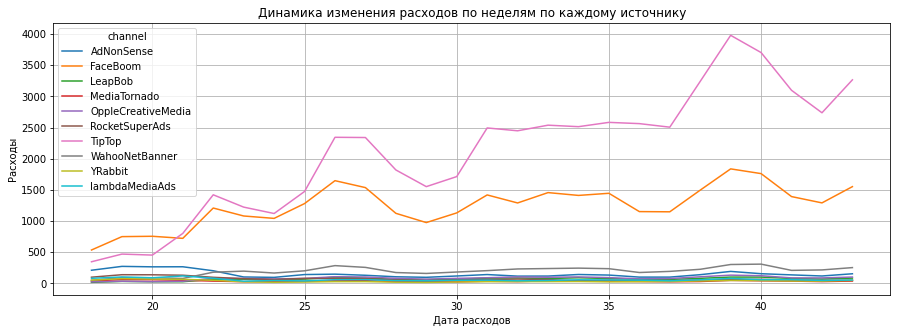

In [23]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs.pivot_table(index = 'week', columns = 'channel', values = 'costs', aggfunc = 'sum').plot(
    grid=True, figsize=(15, 5))
plt.title('Динамика изменения расходов по неделям по каждому источнику')
plt.xlabel('Дата расходов')
plt.ylabel('Расходы')
plt.show()

Несмотря на незначительные колебания в динамике изменения расходов по каждому источниу, больше всего денег компания стабильно тратит на два источника – tiptop и faceboom, тогда как расходы на другие источники не превышают 500 за неделю.

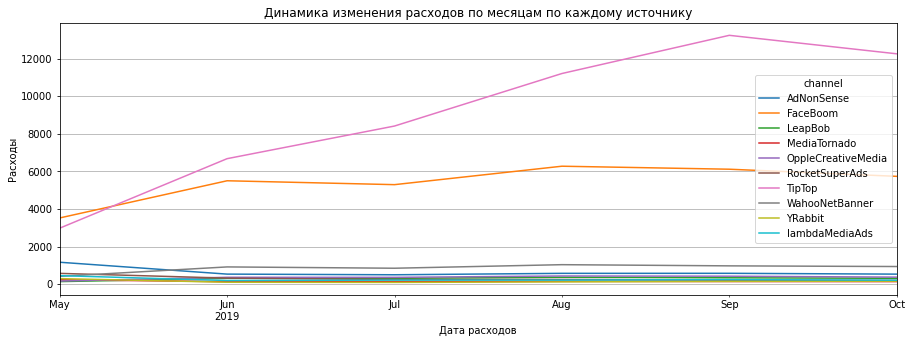

In [24]:
costs['dt'] = costs['dt'].astype('datetime64[M]')  
costs.pivot_table(index = 'dt', columns = 'channel', values = 'costs', aggfunc = 'sum').plot(grid=True, figsize=(15, 5))
plt.title('Динамика изменения расходов по месяцам по каждому источнику')
plt.xlabel('Дата расходов')
plt.xticks(rotation = 45)
plt.ylabel('Расходы')
plt.show()

Несмотря на незначительные колебания в динамике изменения расходов по каждому источниу, больше всего денег компания стабильно тратит на два источника – tiptop и faceboom. До сентября расходы на рекламу в tiptope расли, после сентября начали падать. Расходы на другие источники не превышают 2000 за месяц.

4. Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [27]:
cac = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(
    by='acquisition_cost', ascending=False)
cac

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [28]:
cac.mean()

acquisition_cost    0.687032
dtype: float64

Самое большая стоимость превечения одного пользователя наблюдается в источнике tiptop (2.78), тогда как самое дешевое – LeapBob (0.21), тогда как среднее значение превлечения в общем – 0,69.

Из всех средств (105497.3), которые компания тратит на рекламу, половина идёт на канал TipTop (54751.3), и в последнее время компания только увеличивает капиталовложение в данный маркетинговый канал. Однако, средняя стоимость привлечения одного пользователя с этого канала в несколько раз превышает среднюю стоимость по всем каналам. 

**Шаг 5: оценка окупаемости рекламы**

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы.  

За момент анализа возьмём 1 ноября 2019 года. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, тогда за горизонт анализа возьмём 14 дней. 

1. Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

In [30]:
profiles = profiles.query('channel != "organic"')

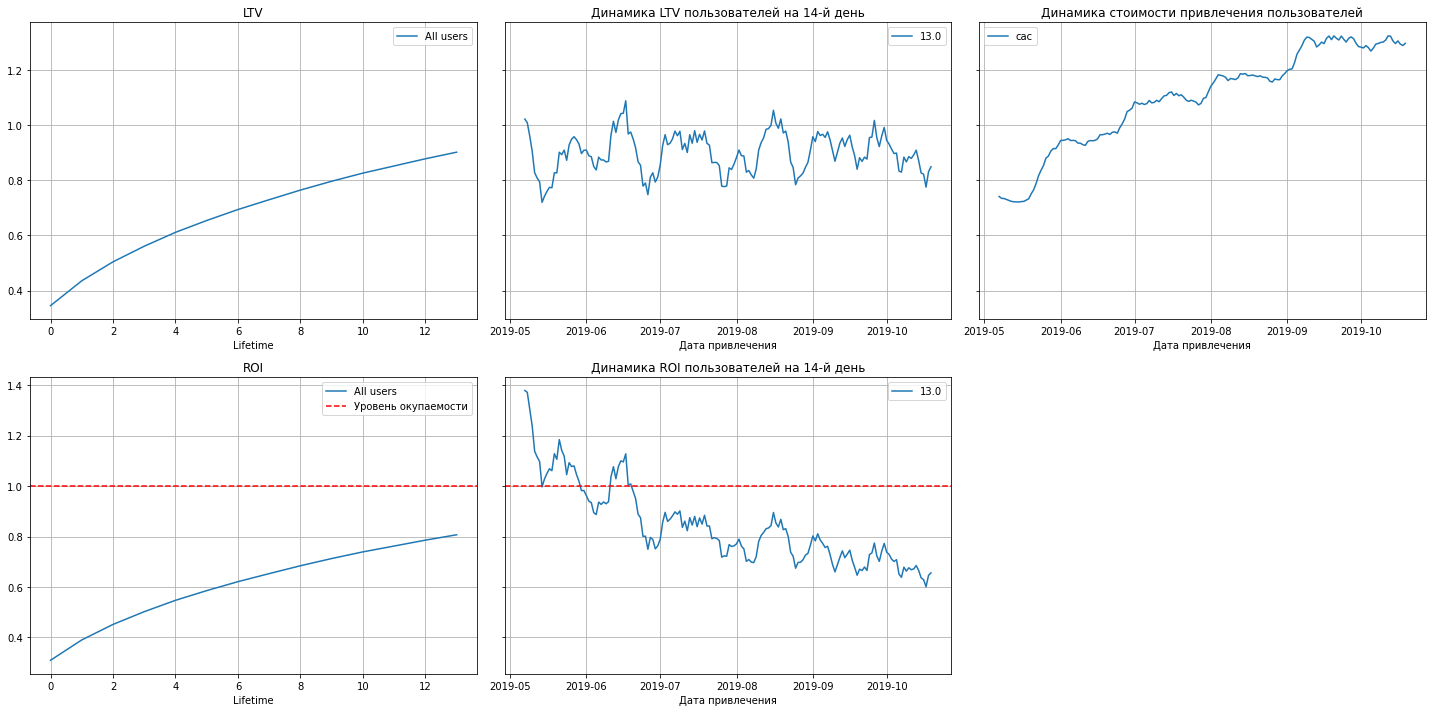

In [31]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
1. Реклама в среднем не окупается и к 14 дню доходит лишь до 80%.
2. CAC не стабилен. Значит, дело в динамике рекламного бюджета. С июля-августа компания стала тратить больше денег на рекламу (стоимость привлечения пользователей увеличилась), тогда же реклама стала реже окупаться (в мае-июле большая часть значени ROI лежит выше окупаемости, тогда как с середины июля реклама практически не окупается).

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

2. Проверим конверсию пользователей и динамику её изменения.

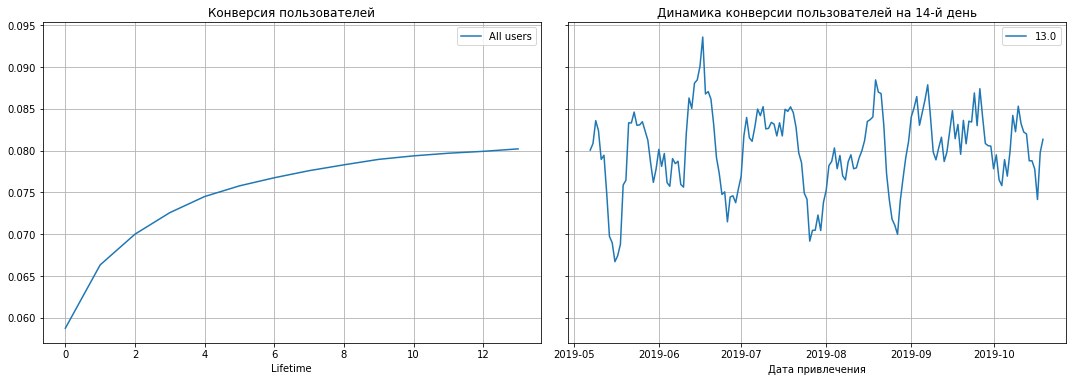

In [32]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

В целом пользователи вплоть до 9-11 дня конвертируются хорошо, однако после 11 дня конверсия идёт на спад и практически не меняется.

3. Проверим удержание пользователей и динамику его изменения.

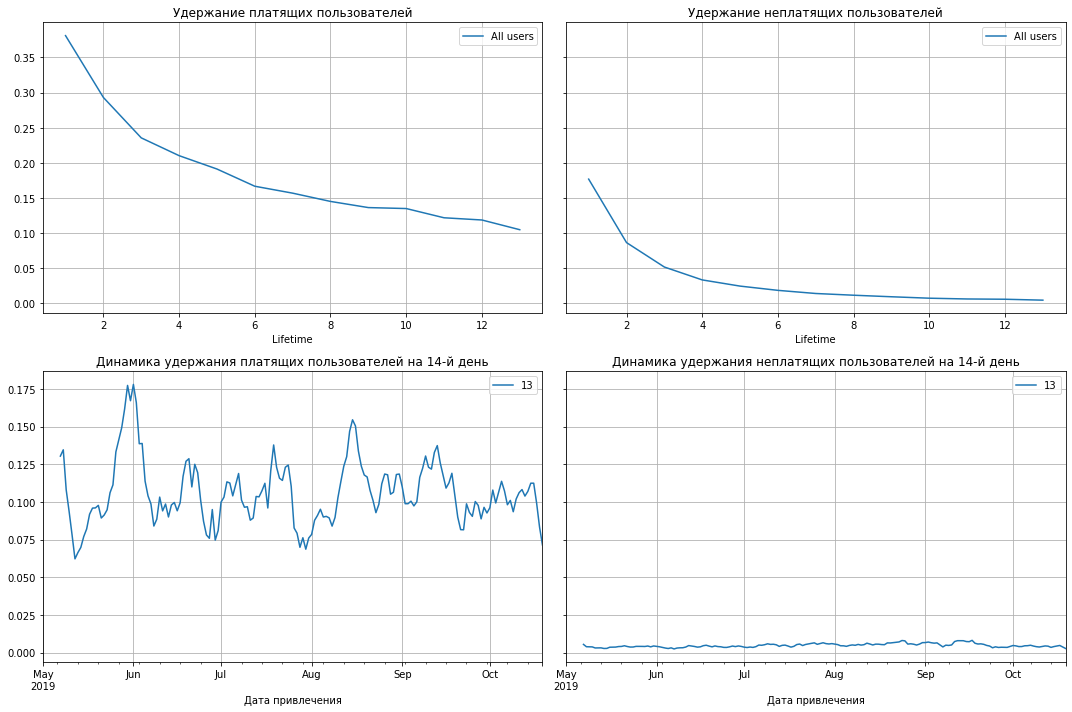

In [33]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Платящие пользователи стабильно лучше удерживаются, чем неплатящие пользователи – значение удержания вплоть до 14 дня превышает 10%, тогда как для неплящих пользователей уже через неделю процент удержания близок к 0. 


4. Проанализируем окупаемость рекламы с разбивкой по устройствам. 

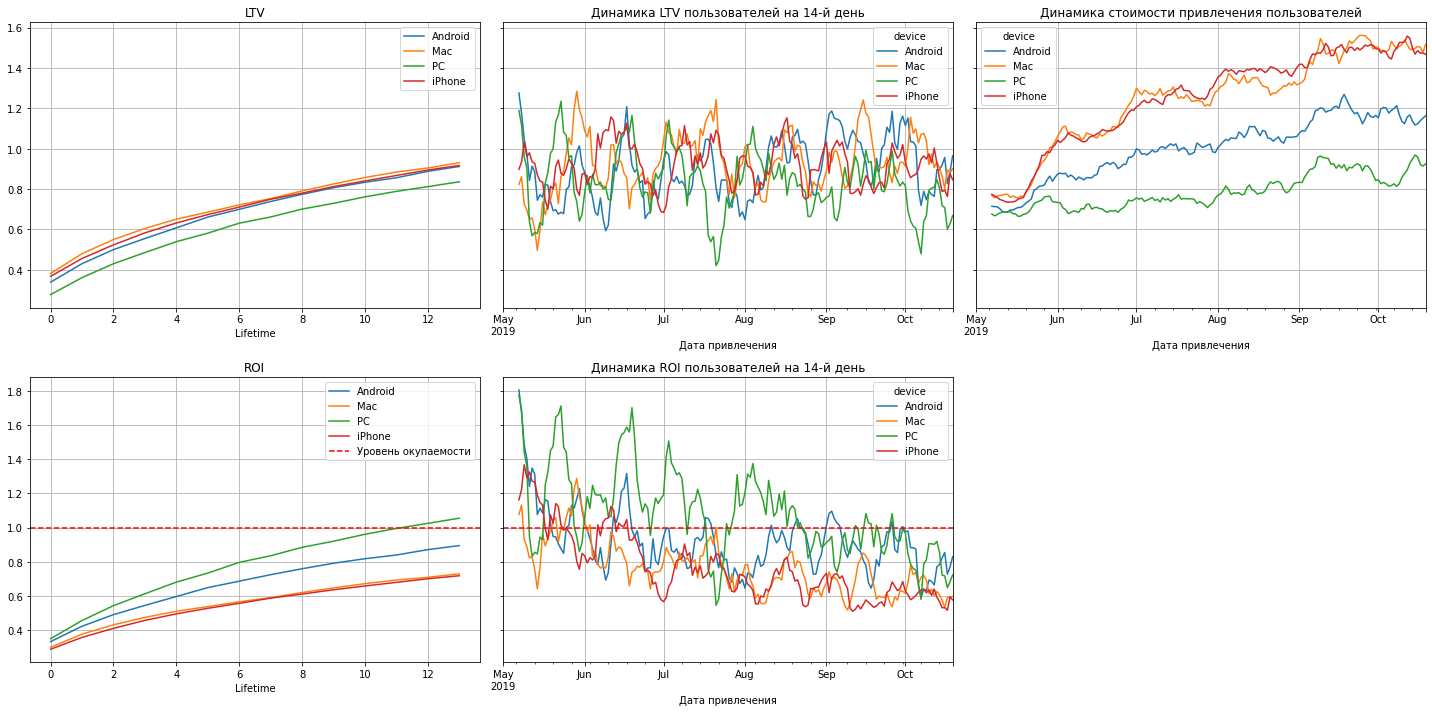

In [34]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
) 

В среднем, вся реклама с разбивкой по устройствам не окупается к 14 дню, кроме PC, которые окупаются уже к 12 дню, тогда как хуже всего окупаются пользователи Mac и iPhone, чье значение ROI чуть превышает 70% к 14 дню, однако для этих пользователей самая большая стоимость привлечения пользователей.

5. Проанализируем окупаемость рекламы с разбивкой по странам.

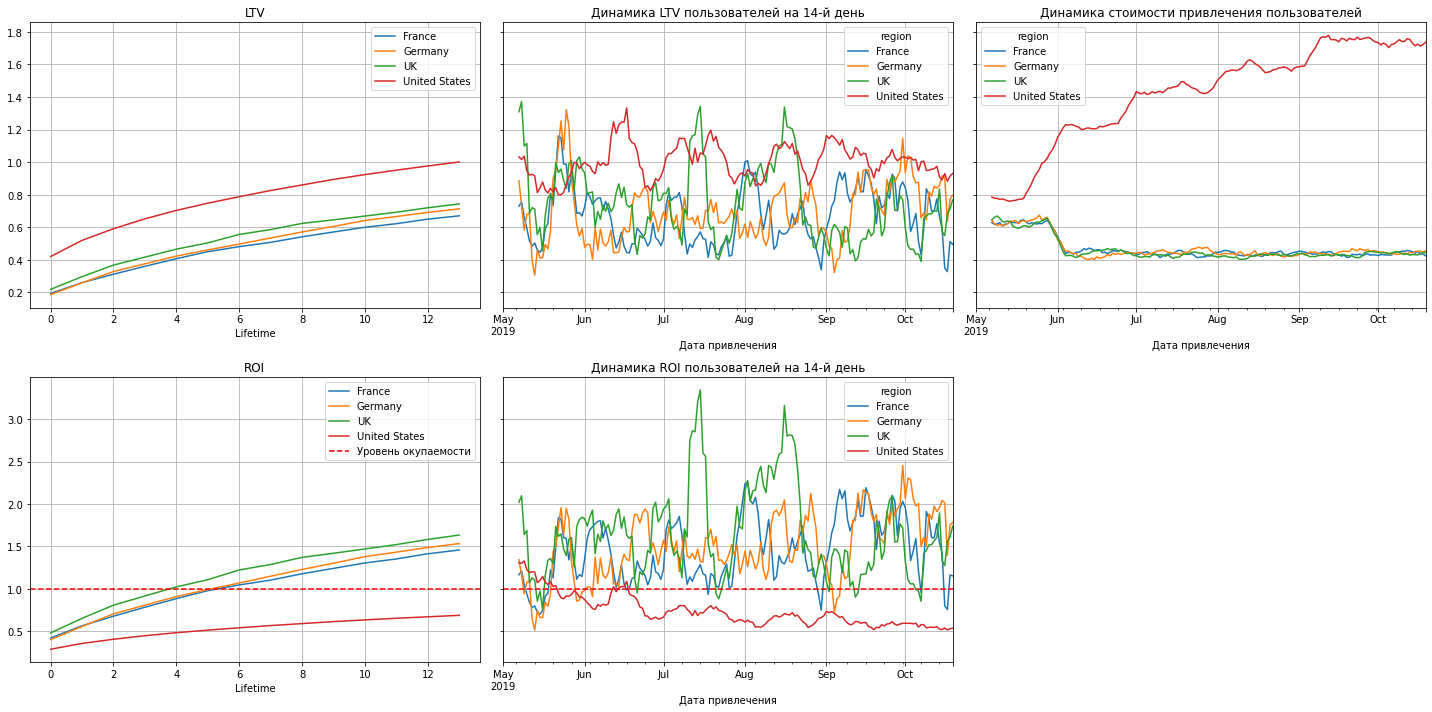

In [35]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
) 

Вот что говорят графики:

1. Реклама не окупается в лишь США.
2. Стоимость привлечения пользователя продолжает увеличваться для США, однако для прочих стран значений практически не меняется, что говорит нам о том, что компания практически не вкладывается в рекламу в прочих странах, хотя уровень окупаемости там выше.
3. LTV всё так же подвержен сезонности.
4. Лучше всего окупается реклама в Великобритании.

6. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

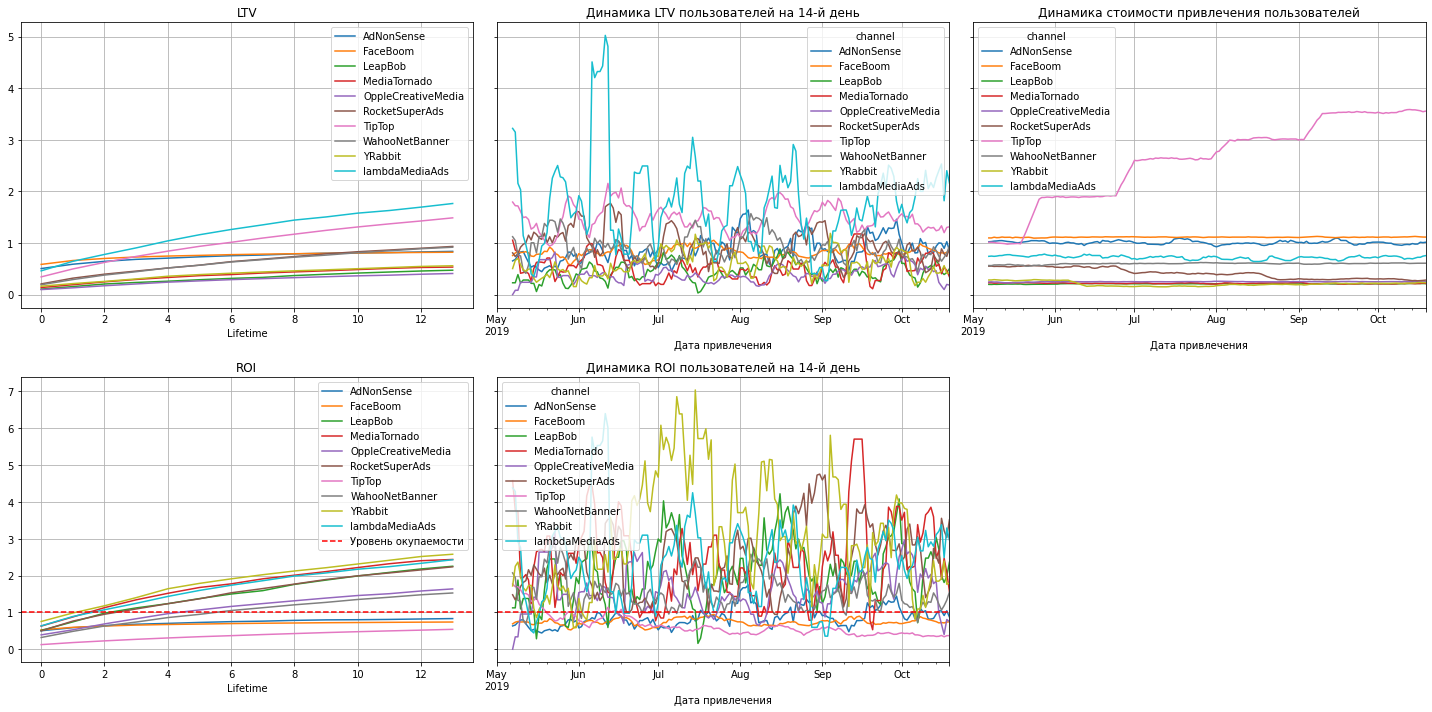

In [36]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
) 

По графикам можно сделать следующие выводы: реклама не окупается в следующих каналах привлечения: adnonsense, faceboom и tiptop, а рекламный канал tiptop, на который компания тратит больше всего рекламного бюджета окупается хуже всего.

Теперь посмотрим на конверсию и удержание в разбивке по:

1. Каналам привлечения
2. Странам
3. Устройствам пользователей

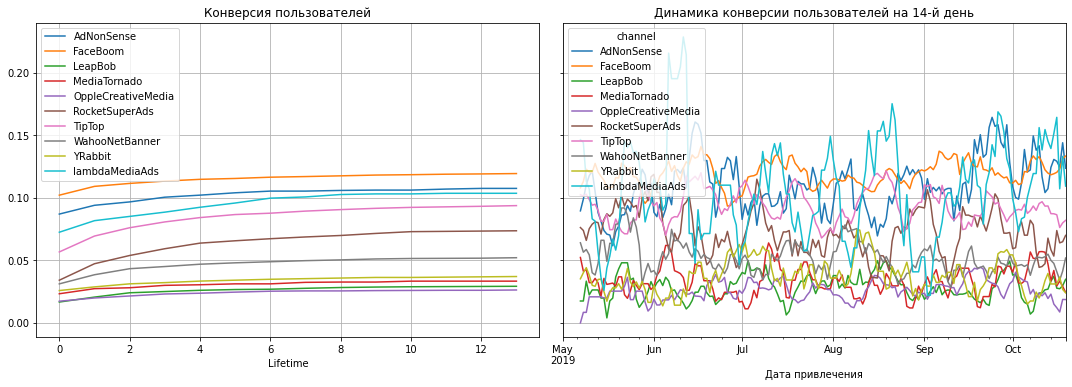

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Тенденции конверсии у всех каналов одинаковые, однако у каналов faceboom, adnonsense, lambdamediaads, tiptop уровень конверсии значительно превосходит остальные каналы привлечения. 

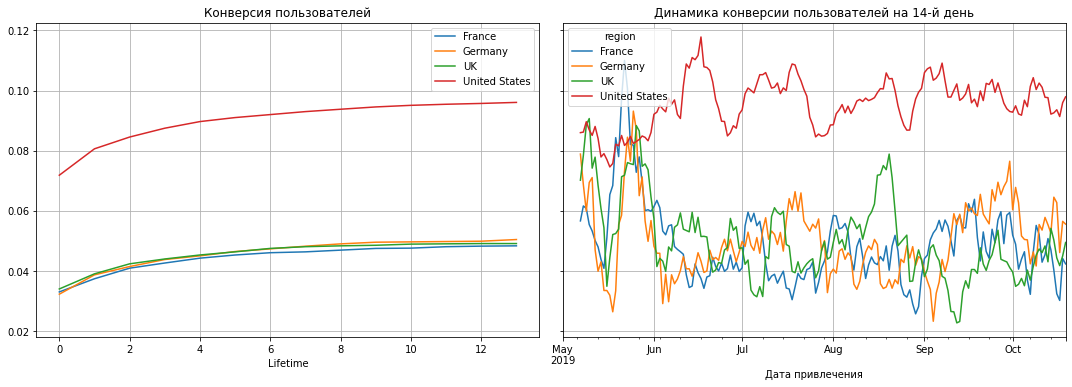

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Тенденции конверсии у всех стран одинаковые, однако у США уровень конверсии значительно превосходит остальные страны.

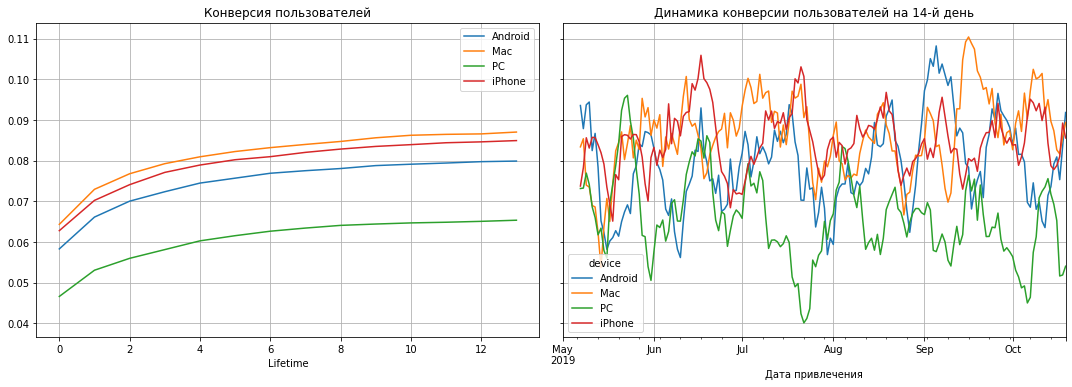

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Тенденции конверсии у всех устройств одинаковые, однако у Мас уровень конверсии превосходит остальные устройства пользователей. Конверсия среди пользователей РС меньше прочих.

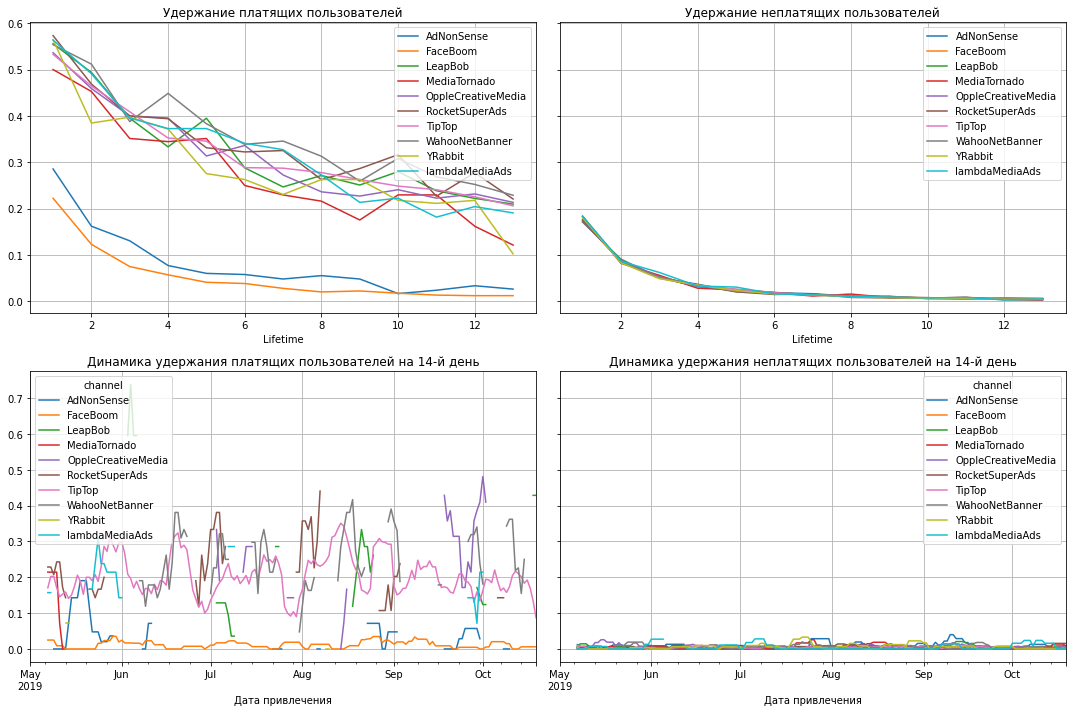

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Уровень удержания неплатящих пользователей среди всех каналов одинаковая, однако среди платящих пользователей выделяются явные аутсайдеры – каналы faceboom, adnonsense.

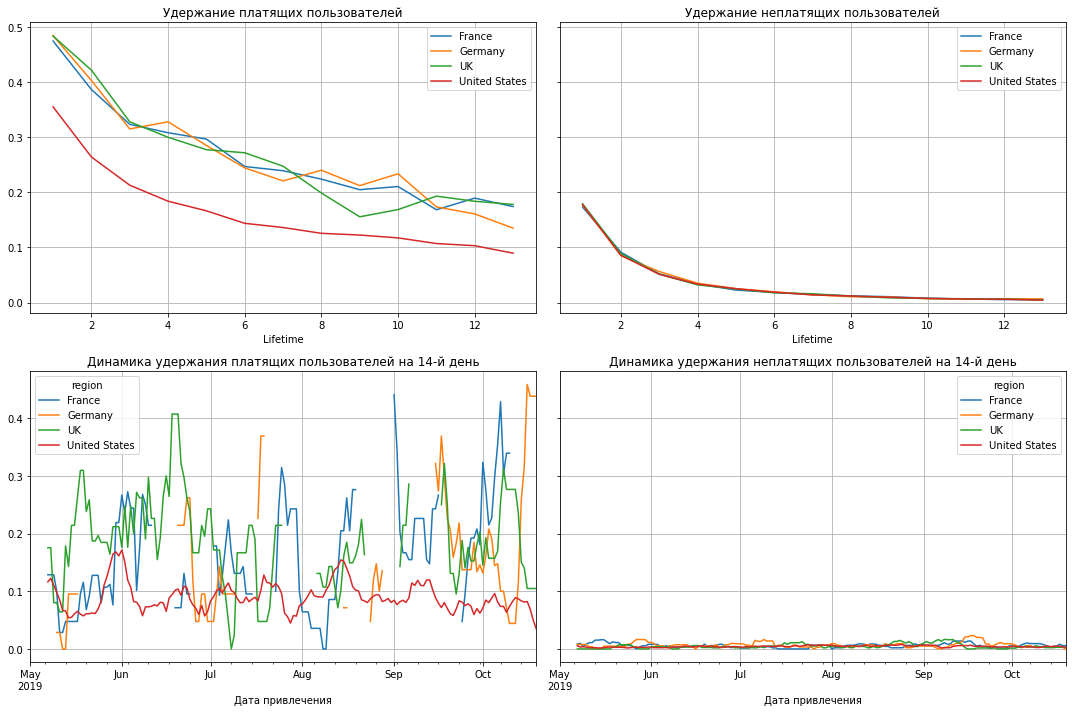

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Уровень удержания неплатящих пользователей среди всех стран одинаковая, однако среди платящих пользователей выделяется явный аутсайдер – США.

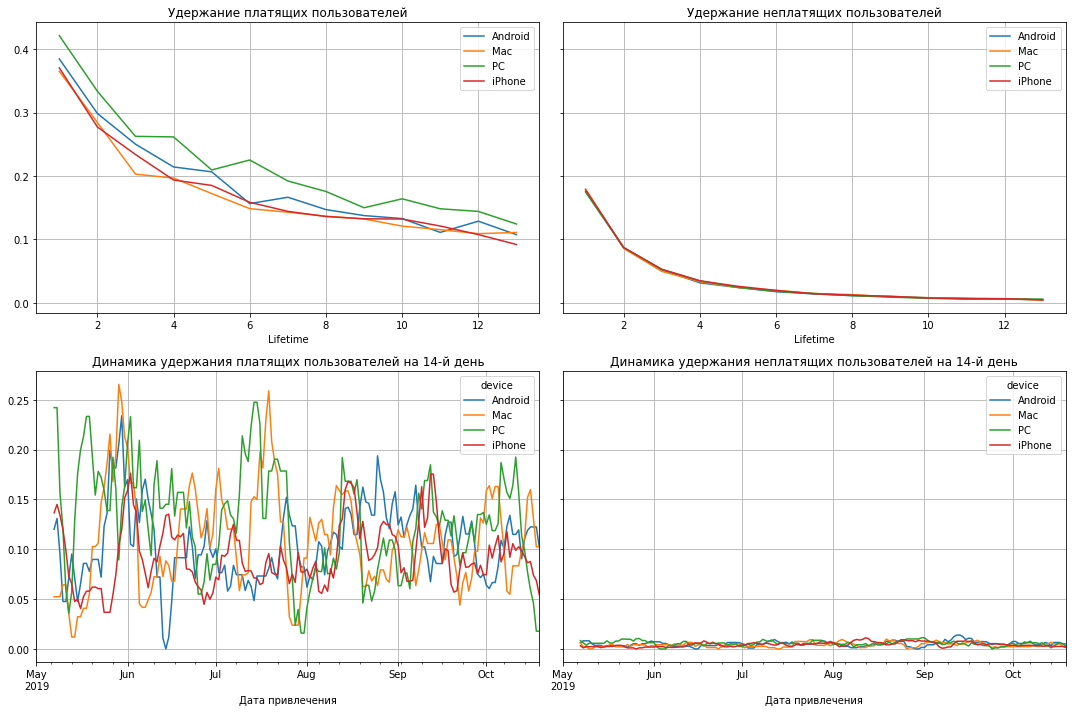

In [42]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Уровень удержания неплатящих пользователей среди всех каналов одинаковая, такая же тенденция наблюдается и среди платящих пользователей. Лучше всего удерживаются пользователи РС, хуже всего пользователи iPhone, однако разница между ними несущественная.

# Выводы #

**На основе полученных нами данных мы провели исследование и выполнили следующие задачи:**

1. Определили, откуда приходят пользователи и какими устройствами они пользуются,
2. Определили, сколько стоит привлечение пользователей из различных рекламных каналов;
3. Определили, сколько денег приносит каждый клиент,
4. Определили, когда расходы на привлечение клиента окупаются,
5. Определим, какие факторы мешают привлечению клиентов.

**Проанализировав данные с 1 мая 2019 года по 27 ноября 2019 года, можно сделать следующие выводы:**

1. Больше всего платящих пользователей приходит из США, меньше всего – из Франции. 
2. Больше всего платящих пользователей пользуются Mac, однако разница с другими устройствами незначительна.
3. Топ-3 каналов, из которых пришло больше всего платящих пользователей – faceboom (12%), adnonsense (11%), lambdamediaads (10%).
4. Больше всего компания тратит на рекламный канал tiptop – в среднем на одного пользователя компания тратит 0.04. 
5. В среднем реклама компании к 14 дню не окупается. Окупаемость значительно упала с середины июля 2019 года.
6. В целом пользователи вплоть до 9-11 дня конвертируются хорошо, однако после 11 дня конверсия идёт на спад и практически не меняется.
7. Платящие пользователи стабильно лучше удерживаются, чем неплатящие пользователи – значение удержания вплоть до 14 дня превышает 10%, тогда как для неплатящих пользователей уже через неделю процент удержания близок к 0.
8. Лучше всего окупаются пользователи PC, тогда как пользователи других устройств не окупаются.
9. Реклама не окупается лишь в США.
10. Реклама не окупается в следующих каналах привлечения: adnonsense, faceboom и tiptop

На основе этих выводов мы можем выявить, что компания с середины июля 2019 года значительно увеличила свой рекламный бюджет, однако направила его преимущественно на США и канал tiptop, которые окупаются хуже всего. Возможно, стоит пересмотреть эту стратегию и нацелится на другие, более прибыльные и рассмотренными нами каналы и страны: например, `Yrabbit` и `RocketSuperAds` – у них самые высокие показатели ROI среди прочих каналов и стабильный уровень конверсии и удержания.